# 프로젝트 2: Reuters 딥러닝 모델

### 데이터 로드 및 전처리

In [4]:
# 필요 패키지(라이브러리) import

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [6]:
# keras.datasets에서 reuters 데이터셋을 로드하고, 
# 파라미터 조정을 통해 단어의 개수는 10000개로 제한합니다

In [7]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [8]:
# 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.

In [9]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, 
                                                                  test_size=0.25, random_state=1)

In [10]:
# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.

In [11]:
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


In [12]:
# 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.

In [13]:
def one_hot_encoding(data, dim=10000):
    results = np.zeros((len(data), dim))
    for i, d in enumerate(data):
        results[i, d] = 1.
    return results

In [14]:
x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

In [15]:
# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.

In [16]:
y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

### 모델 구성 및 컴파일

In [17]:
# 빠른 학습과 과대적합을 방지하기 위해 
# BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.

In [18]:
# 1) 모델 구성

In [19]:
model = models.Sequential([
    layers.Dense(128, input_shape=(10000,), name='input'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.Dense(128, name='hidden'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.Dense(46, activation='softmax', name='output')
])

In [20]:
# 2) 컴파일

In [21]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 128)               1280128   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
hidden (Dense)               (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0

### 모델 학습

In [23]:
# ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.

In [25]:
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', 
                     verbose=1, save_best_only=True)

In [26]:
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [27]:
history = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=512,
                    callbacks=[es, mc],
                    validation_data=(x_val, y_val))

Epoch 1/40
14/14 [==============================] - 2s 49ms/step - loss: 2.3887 - accuracy: 0.5128 - val_loss: 3.3304 - val_accuracy: 0.6977

Epoch 00001: val_accuracy improved from -inf to 0.69768, saving model to best_model.h5
Epoch 2/40
14/14 [==============================] - 0s 17ms/step - loss: 1.1908 - accuracy: 0.7622 - val_loss: 3.0561 - val_accuracy: 0.7293

Epoch 00002: val_accuracy improved from 0.69768 to 0.72930, saving model to best_model.h5
Epoch 3/40
14/14 [==============================] - 0s 18ms/step - loss: 0.8632 - accuracy: 0.8119 - val_loss: 2.7414 - val_accuracy: 0.7391

Epoch 00003: val_accuracy improved from 0.72930 to 0.73909, saving model to best_model.h5
Epoch 4/40
14/14 [==============================] - 0s 17ms/step - loss: 0.6454 - accuracy: 0.8576 - val_loss: 2.4477 - val_accuracy: 0.7262

Epoch 00004: val_accuracy did not improve from 0.73909
Epoch 5/40
14/14 [==============================] - 0s 16ms/step - loss: 0.5027 - accuracy: 0.8907 - val_loss:

In [28]:
# 학습 히스토리의 loss, val_loss, accuracy, val_accuracy를 차트로 시각화합니다.

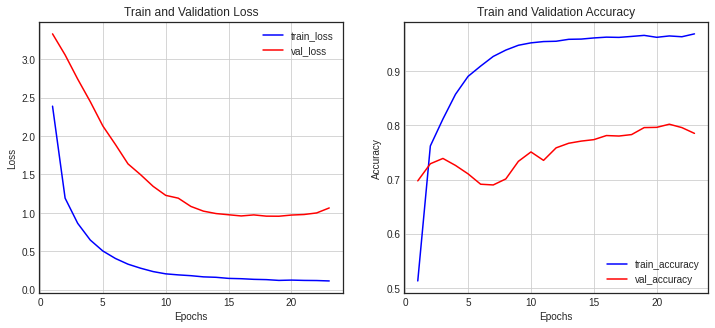

In [29]:
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

### 모델 평가 및 예측

In [31]:
# 테스트 데이터를 이용해 모델 성능을 평가하기

In [32]:
loaded_model = models.load_model('best_model.h5')
loaded_model.evaluate(x_test, y_test)[1]

71/71 [==============================] - 0s 3ms/step - loss: 1.0138 - accuracy: 0.7912


0.7911843061447144